In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [4]:
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [5]:
dataNorm.shape

(20000, 784)

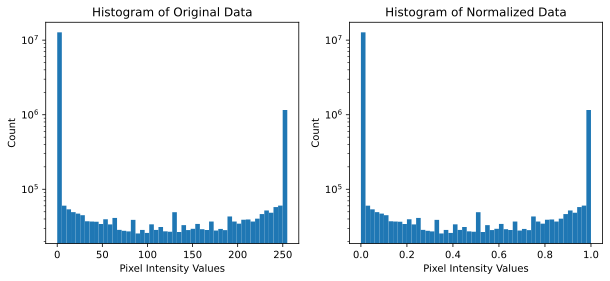

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Original Data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Normalized Data')
ax[1].set_yscale('log')
plt.show()

In [7]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())


In [39]:
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchSize           int              32
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
dataloader          module           <module 'torch.utils.data<...>tils/data/dataloader.py'>
fig                 Figure           Figure(1000x400)
labels              ndarray          20000: 20000 elems, typ

In [8]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = torch.log_softmax(self.output(x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [9]:
def getModel(optimizer, learningRate):
    ANN = Model()
    lossFunction = nn.NLLLoss()
    optimFunc = getattr(torch.optim, optimizer)
    optimizer = optimFunc(params=ANN.parameters(), lr=learningRate)

    return ANN, lossFunction, optimizer

In [10]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 60

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [13]:
optimizers = ['SGD', 'RMSprop', 'Adam']
learningRates = np.logspace(-4, -1, 6)
finalTestAcc = np.zeros((len(learningRates), len(optimizers)))
for optimizersIdx in range(len(optimizers)):
    print("Optimizer: ", optimizers[optimizersIdx])
    for _, learningRate in enumerate(learningRates):
        print("LR: ", learningRate)
        ANN, lossFunction, optimizer = getModel(optimizers[optimizersIdx], learningRate)
        trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)
        finalTestAcc[_, optimizersIdx] = np.mean(testAcc[-10:])

Optimizer:  SGD
LR:  0.0001
LR:  0.00039810717055349735
LR:  0.001584893192461114
LR:  0.00630957344480193
LR:  0.025118864315095794
LR:  0.1
Optimizer:  RMSprop
LR:  0.0001
LR:  0.00039810717055349735
LR:  0.001584893192461114
LR:  0.00630957344480193
LR:  0.025118864315095794
LR:  0.1
Optimizer:  Adam
LR:  0.0001
LR:  0.00039810717055349735
LR:  0.001584893192461114
LR:  0.00630957344480193
LR:  0.025118864315095794
LR:  0.1


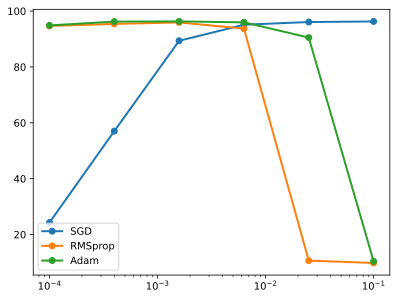

In [14]:
plt.plot(learningRates, finalTestAcc, 'o-',linewidth=2)
plt.legend(optimizers)
plt.xscale('log')
plt.show()